#**Trabalho 3** - Visão Computacional 2022/1

Terceiro trabalho para disciplina de Visão Computacional

Profa. Dra. Raquel Frizera Vassallo

Universidade Federal do Espírito Santo - UFES.

Bruno Guerra Baptista

Thalis Rocha Pestana

14/08/2022

## Libraries

In [ ]:
import numpy as np
from numpy.linalg import inv
import json
import cv2, PIL
from cv2 import aruco
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pandas as pd
import sys

##Functions


In [ ]:
# Function to read the intrinsic and extrinsic parameters of each camera
def camera_parameters(file):
    camera_data = json.load(open(file))
    K = np.array(camera_data['intrinsic']['doubles']).reshape(3, 3)
    res = [camera_data['resolution']['width'],
           camera_data['resolution']['height']]
    tf = np.linalg.inv(np.array(camera_data['extrinsic']['tf']['doubles']).reshape(4, 4))
    R = tf[:3, :3]
    T = tf[:3, 3].reshape(3, 1)
    dis = np.array(camera_data['distortion']['doubles'])
    return K, R, T, res, dis


#Load cameras parameters
K0, R0, T0, res0, dis0 = camera_parameters('0.json')
K1, R1, T1, res1, dis1 = camera_parameters('1.json')
K2, R2, T2, res2, dis2 = camera_parameters('2.json')
K3, R3, T3, res3, dis3 = camera_parameters('3.json')

In [ ]:
file_name0 = "camera-00.mp4" 
file_name1 = "camera-01.mp4" 
file_name2 = "camera-02.mp4" 
file_name3 = "camera-03.mp4" 
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
parameters =  aruco.DetectorParameters_create()
vid0 = cv2.VideoCapture(file_name0)
vid1 = cv2.VideoCapture(file_name1)
vid2 = cv2.VideoCapture(file_name2)
vid3 = cv2.VideoCapture(file_name3)


I = -np.eye(3)
Zeros = np.zeros((3,1))
proj_3d = []
aux=0
while True:
    _, img0 = vid0.read()
    _, img1 = vid1.read()
    _, img2 = vid2.read()
    _, img3 = vid3.read()
    if (img0 is None) or (img1 is None) or (img2 is None) or (img3 is None):
        print("Empty Frame")
        break

    gray0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    corners0, ids0, rejectedimg0Points = aruco.detectMarkers(gray0, aruco_dict, parameters=parameters)
    
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    corners1, ids1, rejectedimg1Points = aruco.detectMarkers(gray1, aruco_dict, parameters=parameters)
   
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    corners2, ids2, rejectedimg2Points = aruco.detectMarkers(gray2, aruco_dict, parameters=parameters)
   
    gray3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
    corners3, ids3, rejectedimg3Points = aruco.detectMarkers(gray3, aruco_dict, parameters=parameters)
        
    if ((ids0 is not None) and (ids0[0]==0)):
      c0 = corners0[0]
      m0 = np.array([[c0[:, :, 0].mean()], [c0[:, :, 1].mean()], [1]])
      W0 = np.dot(np.linalg.inv(np.dot(K0, R0)), m0)
       
    if ((ids1 is not None) and (ids1[0]==0)):
      c1 = corners1[0]
      m1 = np.array([[c1[:, :, 0].mean()], [c1[:, :, 1].mean()], [1]])
      W1 = np.dot(np.linalg.inv(np.dot(K1, R1)), m1)
    if ((ids2 is not None) and (ids2[0]==0)):
      c2 = corners2[0]
      m2 = np.array([[c2[:, :, 0].mean()], [c2[:, :, 1].mean()], [1]])
      W2 = np.dot(np.linalg.inv(np.dot(K2, R2)), m2)
    if ((ids3 is not None) and (ids3[0]==0)):
      c3 = corners3[0]
      m3 = np.array([[c3[:, :, 0].mean()], [c3[:, :, 1].mean()], [1]])
      W3 = np.dot(np.linalg.inv(np.dot(K3, R3)), m3)
      
    if ((ids0 is not None) and (ids0[0].astype(int)==0)) and ((ids1 is not None) and (ids1[0].astype(int)==0)) and ((ids2 is not None) and (ids2[0].astype(int)==0)) and ((ids3 is not None) and (ids3[0].astype(int)==0)):
      W = np.vstack((np.hstack((I, W0, Zeros, Zeros, Zeros)), 
                    np.hstack((I, Zeros, W1, Zeros, Zeros)),
                    np.hstack((I, Zeros, Zeros, W2, Zeros)),
                    np.hstack((I, Zeros, Zeros, Zeros, W3))))
      W_inv = np.linalg.pinv(W)
      
      RT = np.vstack((np.dot(np.linalg.inv(R0),T0), 
                      np.dot(np.linalg.inv(R1),T1), 
                      np.dot(np.linalg.inv(R2),T2), 
                      np.dot(np.linalg.inv(R3),T3)))
      proj_3d.append(np.dot(W_inv,RT))

    elif ((ids1 is not None) and (ids1[0].astype(int)==0)) and (ids2 is not None and (ids2[0].astype(int)==0)) and ((ids3 is not None and (ids3[0].astype(int)==0))):
      
      W = np.vstack((np.hstack((I, W1, Zeros, Zeros)), 
                    np.hstack((I, Zeros, W2, Zeros)),
                    np.hstack((I, Zeros, Zeros, W3))))
      W_inv = np.linalg.pinv(W)
      RT = np.vstack((np.dot(np.linalg.inv(R1),T1), 
                      np.dot(np.linalg.inv(R2),T2), 
                      np.dot(np.linalg.inv(R3),T3)))
      proj_3d.append(np.dot(W_inv,RT))
     
    elif ((ids0 is not None) and (ids0[0].astype(int)==0)) and ((ids2 is not None) and (ids2[0].astype(int)==0)) and ((ids3 is not None) and (ids3[0].astype(int)==0)):
      W = np.vstack((np.hstack((I, W0, Zeros, Zeros)), 
                    np.hstack((I, Zeros, W2, Zeros)),
                    np.hstack((I, Zeros, Zeros, W3))))
      W_inv = np.linalg.pinv(W)
      RT = np.vstack((np.dot(np.linalg.inv(R0),T0), 
                      np.dot(np.linalg.inv(R2),T2), 
                      np.dot(np.linalg.inv(R3),T3)))
      proj_3d.append(np.dot(W_inv,RT))
      
    elif ((ids0 is not None) and (ids0[0].astype(int)==0)) and ((ids1 is not None) and (ids1[0].astype(int)==0)) and ((ids3 is not None) and (ids3[0].astype(int)==0)):
      W = np.vstack((np.hstack((I, W0, Zeros, Zeros)), 
                    np.hstack((I, Zeros, W1, Zeros)),
                    np.hstack((I, Zeros, Zeros, W3))))
      W_inv = np.linalg.pinv(W)
      RT = np.vstack((np.dot(np.linalg.inv(R0),T0), 
                      np.dot(np.linalg.inv(R1),T1), 
                      np.dot(np.linalg.inv(R3),T3)))
      proj_3d.append(np.dot(W_inv,RT))
     
    elif ((ids0 is not None) and (ids0[0].astype(int)==0)) and ((ids1 is not None) and (ids1[0].astype(int)==0)) and ((ids2 is not None) and (ids2[0].astype(int)==0)):
      W = np.vstack((np.hstack((I, W0, Zeros, Zeros)), 
                    np.hstack((I, Zeros, W1, Zeros)),
                    np.hstack((I, Zeros, Zeros, W2))))
      W_inv = np.linalg.pinv(W)
      RT = np.vstack((np.dot(np.linalg.inv(R0),T0), 
                      np.dot(np.linalg.inv(R1),T1), 
                      np.dot(np.linalg.inv(R2),T2)))
      proj_3d.append(np.dot(W_inv,RT))
     
    elif ((ids0 is not None) and (ids0[0].astype(int)==0)) and ((ids1 is not None) and (ids1[0].astype(int)==0)):
      W = np.vstack((np.hstack((I, W0, Zeros)), 
                    np.hstack((I, Zeros, W1))))
      W_inv = np.linalg.pinv(W)
      RT = np.vstack((np.dot(np.linalg.inv(R0),T0), 
                      np.dot(np.linalg.inv(R1),T1)))
      proj_3d.append(np.dot(W_inv,RT))
     
    elif ((ids0 is not None) and (ids0[0].astype(int)==0)) and ((ids2 is not None) and (ids2[0].astype(int)==0)):
      W = np.vstack((np.hstack((I, W0, Zeros)), 
                    np.hstack((I, Zeros, W2))))
      W_inv = np.linalg.pinv(W)
      RT = np.vstack((np.dot(np.linalg.inv(R0),T0), 
                      np.dot(np.linalg.inv(R2),T2)))
      proj_3d.append(np.dot(W_inv,RT))
    
    elif ((ids0 is not None) and (ids0[0].astype(int)==0)) and ((ids3 is not None) and (ids3[0].astype(int)==0)):
      W = np.vstack((np.hstack((I, W0, Zeros)), 
                    np.hstack((I, Zeros, W3))))
      W_inv = np.linalg.pinv(W)
      RT = np.vstack((np.dot(np.linalg.inv(R0),T0), 
                      np.dot(np.linalg.inv(R3),T3)))
      proj_3d.append(np.dot(W_inv,RT))
     
    elif ((ids1 is not None) and (ids1[0].astype(int)==0)) and ((ids2 is not None) and (ids2[0].astype(int)==0)):
      W = np.vstack((np.hstack((I, W1, Zeros)), 
                    np.hstack((I, Zeros, W2))))
      W_inv = np.linalg.pinv(W)
      RT = np.vstack((np.dot(np.linalg.inv(R1),T1), 
                      np.dot(np.linalg.inv(R2),T2)))
      proj_3d.append(np.dot(W_inv,RT))
     
    elif ((ids1 is not None) and (ids1[0].astype(int)==0)) and ((ids3 is not None) and (ids3[0].astype(int)==0)):
      W = np.vstack((np.hstack((I, W1, Zeros)), 
                    np.hstack((I, Zeros, W3))))
      W_inv = np.linalg.pinv(W)
      RT = np.vstack((np.dot(np.linalg.inv(R1),T1), 
                      np.dot(np.linalg.inv(R3),T3)))
      proj_3d.append(np.dot(W_inv,RT))
      
    elif ((ids2 is not None) and (ids2[0].astype(int)==0)) and ((ids3 is not None) and (ids3[0].astype(int)==0)):
      W = np.vstack((np.hstack((I, W2, Zeros)), 
                    np.hstack((I, Zeros, W3))))
      W_inv = np.linalg.pinv(W)
      RT = np.vstack((np.dot(np.linalg.inv(R2),T2), 
                      np.dot(np.linalg.inv(R3),T3)))
      proj_3d.append(np.dot(W_inv,RT))
      
    if cv2.waitKey(1) == ord('q'):
        break

cv2.destroyAllWindows()

Empty Frame


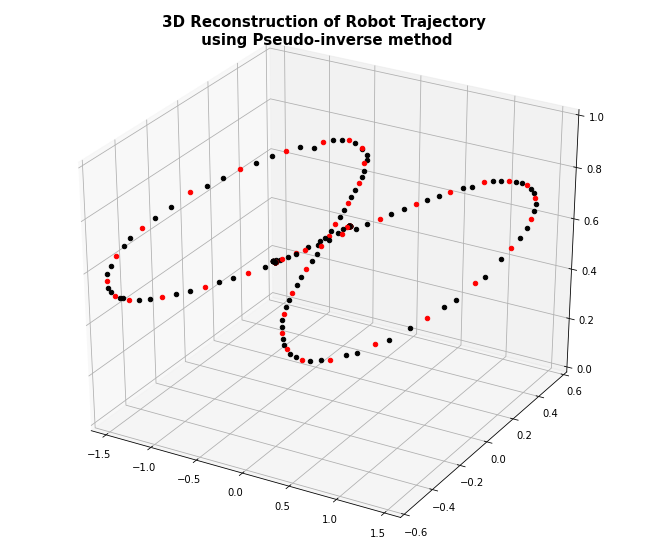

In [ ]:
import itertools

fig = plt.figure(figsize=(25,10))
ax0 = fig.add_subplot(1,2,1, projection='3d')

plt.title('3D Reconstruction of Robot Trajectory\n using Pseudo-inverse method', fontweight='bold', size=15)  
ax0.set_xlim([-1.6,1.6])
ax0.set_ylim([-0.6,0.6])
ax0.set_zlim([0,1])

x = np.arange(2)
ys = [i+x+(i*x)**2 for i in range(10)]
colors = itertools.cycle(["black","black","red"])

for index in range(len(proj_3d)):
  ax0.scatter(np.array(proj_3d[index])[0], np.array(proj_3d[index])[1], np.array(proj_3d[index])[2], color=next(colors))
  
